# Red Sox Pregame Analysis

This notebook explores T traffic before Sox games.

## Setup

In [1]:
# Libraries.
import datetime as dt
import math
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [2]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

In [3]:
# Other settings.

# Default figure size.
default_figsize = (12,8)
default_figsize_slides = (12,6)

# Base units of timedeltas.
timedelta_base = 3.6e12

## Data

### Sox

In [4]:
# Read Red Sox home games.
sox = pd.DataFrame.from_csv("../../../data/sox_master.csv").reset_index(drop=True)

# Rename other columns to make joining easy.
sox.rename(columns={'START_DATE':'game_date', 'START_TIME':'game_time', 'OPPONENT':'opponent'}, inplace=True)

# Drop 0s from start date.
sox.game_date = sox.game_date.str.extract('(\d+-\d+-\d+)')
# Column for start datetime.
sox['game_datetime'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time)

# Add a "rounded" game time to make grouping easier.
sox['game_time_rounded'] = sox.game_time.str.replace(':[012][05] ',':00 ').str.replace(':[345][05] ',':30 ')
sox['game_datetime_rounded'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time_rounded)

# Turn start date into a date.
sox.game_date = pd.to_datetime(sox.game_date)

# Convert time fields to times.
sox.game_time = pd.DatetimeIndex(sox.game_datetime).time
sox.game_time_rounded = pd.DatetimeIndex(sox.game_datetime_rounded).time

In [ ]:
sox.head()

### Gatecount

In [5]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/mbta.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to columns that we need.
gatecount = gatecount.ix[:,['locationid','name','line_1','line_2','service_day','service_datetime','entries']].reset_index(drop=True)

# Turn days/dates into datetimes.
gatecount.service_day = pd.to_datetime(gatecount.service_day)
gatecount.service_datetime = pd.to_datetime(gatecount.service_datetime)

# Get time of day.
gatecount['service_time'] = pd.DatetimeIndex(gatecount.service_datetime).time

# Add day of week.
gatecount = date.add_day_of_week(gatecount.copy())

In [ ]:
gatecount.head()

In [6]:
# Perform merge.
gatecount_sox = gatecount.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
gatecount_sox['game_played'] = (gatecount_sox.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
gatecount_sox['time_until_game_start'] = gatecount_sox.game_datetime_rounded - gatecount_sox.service_datetime

# Separate into classes: weekday/weekend and early/late.
gatecount_sox['day_of_week_class'] = 'Weekday'
gatecount_sox.ix[gatecount_sox.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
gatecount_sox['game_time_class'] = 'Early'
gatecount_sox.ix[gatecount_sox.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

# Add line count and an "entries per line" column for each station.
gatecount_sox['lines'] = 1
gatecount_sox.ix[gatecount_sox.line_2.isnull() == False,'lines'] = 2
gatecount_sox['entries_per_line'] = gatecount_sox.entries / gatecount_sox.lines

# Clean up lines.
gatecount_sox.line_1 = ['None' if type(l) == float and math.isnan(l) else l for l in gatecount_sox.line_1]
gatecount_sox.line_2 = ['None' if type(l) == float and math.isnan(l) else l for l in gatecount_sox.line_2]

In [ ]:
gatecount_sox[gatecount_sox.game_played].head()

### Farebox

In [7]:
# Path for routes.
routes_file = '../../../data/SignCodesAndRoutes.csv'

# Get routes.
routes = pd.read_csv(routes_file)
# Restrict to Green Line D.
gl_routes = routes[(routes['mode'] == 'G/Line') & routes.publicroute.isin(['Green Line '+l for l in 'BCDE'])]
# Get signcodes.
gl_signcodeids = set(gl_routes.signcodeid)

# Get simplified version for merge.
gl_sc_pr = gl_routes[['signcodeid','publicroute']]

In [ ]:
gl_routes

In [8]:
# Farebox directories.
farebox_root = '../../../data/farebox_all/'

# Empty container for data.
farebox = None
# Traverse each file and add to the main.
for farebox_file in os.listdir(farebox_root):
    farebox_month = pd.read_csv(farebox_root+farebox_file)
    if farebox is None:
        farebox = farebox_month
    else:
        farebox = farebox.append(farebox_month)

# Restrict to green line D. Discard old farebox data.
gl_farebox = farebox[farebox.signcodeid.isin(gl_signcodeids)]
del farebox

# Calculate entries.
gl_farebox['entries'] = gl_farebox.charlie + gl_farebox.cash

# Drop old columns.
gl_farebox.drop(['charlie','cash'], axis=1, inplace=True)

# Rename some columns for consistency.
gl_farebox.rename(columns={'servicedate':'service_day', 'servicetime':'service_time'}, inplace=True)

# Make service_day a string for now.
gl_farebox.service_day = gl_farebox.service_day.astype(np.str)

# Fix dates and times for post-midnight 
gl_farebox_post_midnight = gl_farebox[gl_farebox.service_time >= 2400]
# Fix times.
gl_farebox_post_midnight.service_time = gl_farebox_post_midnight.service_time-2400
# Fix dates.
gl_farebox_post_midnight.service_day = pd.to_datetime(gl_farebox_post_midnight.service_day) + np.timedelta64(1,'D')
gl_farebox_post_midnight.service_day = pd.DatetimeIndex(gl_farebox_post_midnight.service_day).format()
# Get pre-midnight data.
gl_farebox_pre_midnight = gl_farebox[gl_farebox.service_time < 2400]
# Recombine.
gl_farebox = gl_farebox_pre_midnight.append(gl_farebox_post_midnight)
# Housekeeping.
del gl_farebox_pre_midnight, gl_farebox_post_midnight

# Zero-pad service times.
gl_farebox.service_time = gl_farebox.service_time.map('{:04}'.format)

# Derive datetime.
gl_farebox['service_datetime'] = pd.to_datetime(gl_farebox.service_day + ' ' + gl_farebox.service_time)

# Re-derive service time.
gl_farebox.service_time = pd.DatetimeIndex(gl_farebox['service_datetime']).time

# Turn plain day into a datetime and get day of week.
gl_farebox.service_day = pd.to_datetime(gl_farebox.service_day)
gl_farebox['day_of_week'] = pd.DatetimeIndex(gl_farebox.service_day).weekday

# Identify outbound/outbound routes.
gl_farebox['inbound'] = (gl_farebox.signcodeid % 10).astype(np.bool)

# Merge with publicroute information.
gl_farebox = gl_farebox.merge(gl_sc_pr, on='signcodeid')

# Aggregate by inbound/outbound, publicroute.
gl_farebox = gl_farebox.groupby(['service_day','service_time','service_datetime','day_of_week','inbound','publicroute']).agg(np.sum).reset_index()

# Perform final aggregation in case of multiple signcodeid entries.
# gl_farebox_agg = gl_farebox.groupby(['service_day','service_time','service_datetime','day_of_week','inbound']).agg(np.sum).reset_index()
gl_farebox.drop(['signcodeid'], axis=1, inplace=True)

/usr/local/Cellar/python/2.7.6/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/generic.py:2005: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [70]:
gl_farebox.head()

,service_day,service_time,service_datetime,day_of_week,inbound,publicroute,entries
0,2013-01-01,03:30:00,2013-01-01 03:30:00,1,True,Green Line C,1
1,2013-01-01,03:45:00,2013-01-01 03:45:00,1,True,Green Line C,4
2,2013-01-01,04:45:00,2013-01-01 04:45:00,1,True,Green Line C,3
3,2013-01-01,05:15:00,2013-01-01 05:15:00,1,False,Green Line D,1
4,2013-01-01,05:15:00,2013-01-01 05:15:00,1,True,Green Line B,9


In [9]:
# Perform merge.
farebox_sox = gl_farebox.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
farebox_sox['game_played'] = (farebox_sox.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
farebox_sox['time_until_game_start'] = farebox_sox.game_datetime_rounded - farebox_sox.service_datetime

# Separate into classes: weekday/weekend and early/late.
farebox_sox['day_of_week_class'] = 'Weekday'
farebox_sox.ix[farebox_sox.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
farebox_sox['game_time_class'] = 'Early'
farebox_sox.ix[farebox_sox.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

In [ ]:
farebox_sox[farebox_sox.game_played].head()

## Aggregate, Controlling for Day of Week

### Gatecount

Let's compare entries across the system on gamedays to days with no games, controlling for day of week.

In [10]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
gameless_entries_dow = gatecount_sox[gatecount_sox.game_played == False]

# Aggregate.
gameless_entries_dow = gameless_entries_dow.groupby(['name','line_1','line_2','day_of_week','service_time']).agg({'entries': np.mean, 'entries_per_line': np.mean}).reset_index()
gameless_entries_dow.rename(columns={'entries':'mean_entries', 'entries_per_line': 'mean_entries_per_line'}, inplace=True)

In [28]:
# Only consider entries before the game or slightly into it (to determine when entries dissipate.
gametime_condition = ((gatecount_sox.time_until_game_start <= np.timedelta64(6,'h')) & (gatecount_sox.time_until_game_start >= np.timedelta64(-90,'m')))
game_entries_dow = gatecount_sox[gatecount_sox.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_dow = game_entries_dow.merge(gameless_entries_dow, on=['name','line_1','line_2','day_of_week','service_time'])[['name','line_1','line_2','entries','entries_per_line','time_until_game_start','mean_entries','mean_entries_per_line']]
entry_differences_dow['entries_vs_mean'] = entry_differences_dow.entries - entry_differences_dow.mean_entries
entry_differences_dow['entries_vs_mean_ratio'] = entry_differences_dow.entries / entry_differences_dow.mean_entries
entry_differences_dow['entries_vs_mean_per_line'] = entry_differences_dow.entries_per_line - entry_differences_dow.mean_entries_per_line
entry_differences_dow['entries_vs_mean_per_line_ratio'] = entry_differences_dow.entries_per_line / entry_differences_dow.mean_entries_per_line

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
# Also retain mean entries for later plotting.
mean_entry_differences_dow = entry_differences_dow.groupby(['name','line_1','line_2','time_until_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std],
        'entries_vs_mean_per_line': [np.mean,np.std],
        'entries_vs_mean_per_line_ratio': [np.mean,np.std],
        'mean_entries': np.mean,
        'mean_entries_per_line': np.mean
    }).reset_index()
mean_entry_differences_dow.time_until_game_start = pd.to_timedelta(mean_entry_differences_dow.time_until_game_start)
mean_entry_differences_dow['hours_until_game_start'] = mean_entry_differences_dow.time_until_game_start.astype(np.int) / timedelta_base

In [ ]:
mean_entry_differences_dow.head()

In [61]:
# Extract useful information.
mean_entry_differences_dow_truncated = mean_entry_differences_dow[[0,1,2,14,6,4,10,11]].copy()
mean_entry_differences_dow_truncated.columns = mean_entry_differences_dow_truncated.columns.get_level_values(0)

In [62]:
mean_entry_differences_dow_truncated.head()

,name,line_1,line_2,hours_until_game_start,entries_vs_mean,entries_vs_mean_per_line,mean_entries,mean_entries_per_line
0,Airport,Blue,None,-1.50,9.132825,9.132825,80.631881,80.631881
1,Airport,Blue,None,-1.25,12.531234,12.531234,71.321708,71.321708
2,Airport,Blue,None,-1.00,8.952860,8.952860,75.647140,75.647140
3,Airport,Blue,None,-0.75,13.145667,13.145667,72.230804,72.230804
4,Airport,Blue,None,-0.50,13.878554,13.878554,74.380269,74.380269


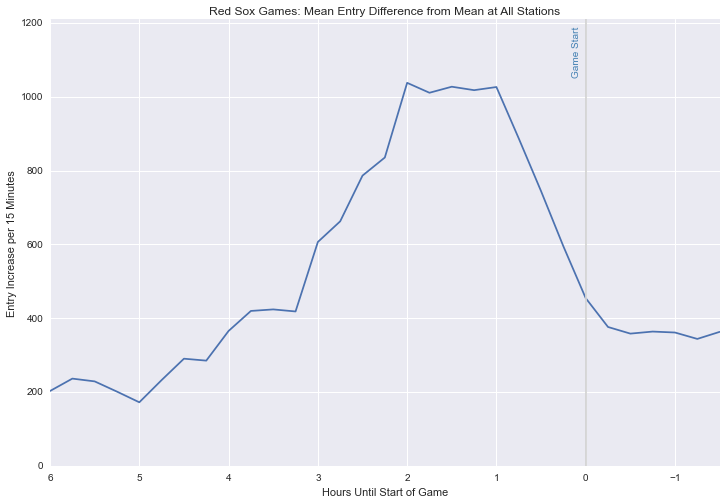

In [63]:
# Plot aggregate.

# Group by hours until start and aggregate.
mean_entry_differences_dow_agg = mean_entry_differences_dow_truncated.groupby('hours_until_game_start').agg(np.sum).reset_index()

# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(mean_entry_differences_dow_agg.hours_until_game_start, mean_entry_differences_dow_agg.entries_vs_mean)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at All Stations')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)

# Show.
plt.show()

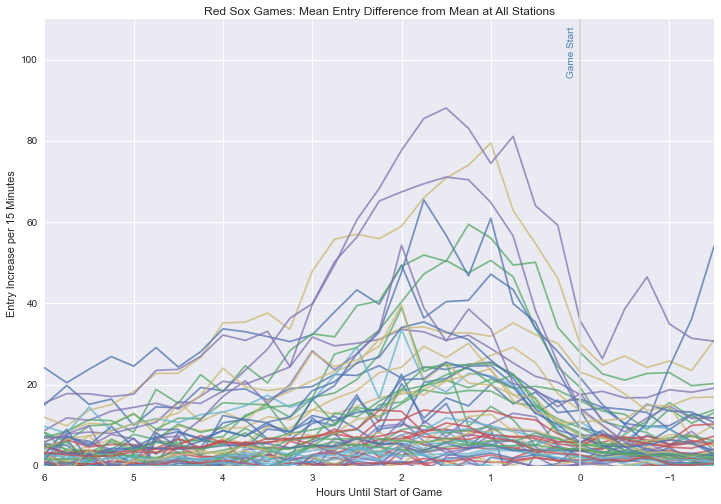

In [64]:
# Now plot them. Plot one line per station.

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for station in mean_entry_differences_dow.name.unique():
    # Get station entries.
    station_entry_differences = mean_entry_differences_dow[mean_entry_differences_dow.name == station]
    plt.plot(station_entry_differences.hours_until_game_start, station_entry_differences.entries_vs_mean['mean'], label=station, alpha=0.75)
    # Add note about total over time range.

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at All Stations')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)

# Show.
plt.show()

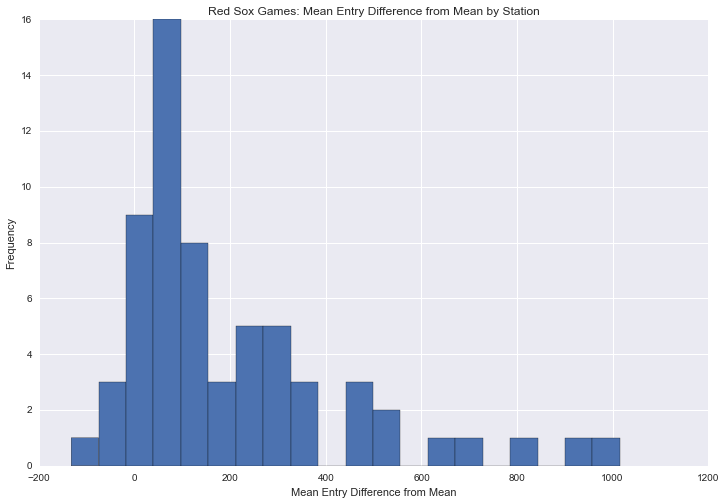

In [70]:
# Calculate sums for each station and plot distribution.

# Calculate sum for each station.
mean_entry_differences_dow_by_station = mean_entry_differences_dow_truncated.ix[(mean_entry_differences_dow_truncated.hours_until_game_start > -.5) & (mean_entry_differences_dow_truncated.hours_until_game_start <= 4),:].groupby(['name','line_1','line_2']).agg({'entries_vs_mean': np.sum, 'mean_entries': np.sum})

# Start plotting.
plt.figure(figsize=default_figsize)
plt.hist(mean_entry_differences_dow_by_station.entries_vs_mean, bins=20)

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean by Station')
plt.xlabel('Mean Entry Difference from Mean'); plt.ylabel('Frequency')

# Show.
plt.show()

Version for slides:

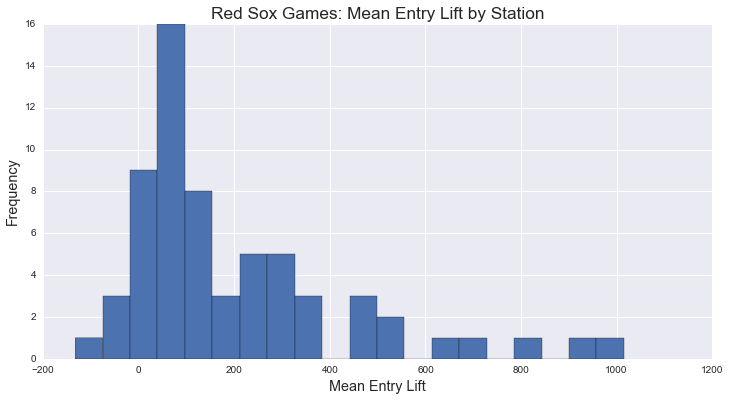

In [71]:
# Start plotting.
plt.figure(figsize=default_figsize_slides)
plt.hist(mean_entry_differences_dow_by_station.entries_vs_mean, bins=20)

# Prettify.
plt.title('Red Sox Games: Mean Entry Lift by Station', fontsize='xx-large')
plt.xlabel('Mean Entry Lift', fontsize='x-large'); plt.ylabel('Frequency', fontsize='x-large')

# Show.
plt.show()

In [72]:
# Show particular high-volume stations.
mean_entry_differences_dow_by_station.sort('entries_vs_mean', ascending=False).head(n=10)

,,,mean_entries,entries_vs_mean
name,line_1,line_2,,
Park Street,Green,Red,6544.652416,1014.853466
Government Center,Green,Blue,3656.555402,927.197407
Riverside,Green,None,513.097956,807.002044
Haymarket,Orange,Green,3287.435872,687.511187
Harvard,Red,None,6607.568435,639.160976
North Station,Orange,Green,3746.493165,531.889188
Alewife,Red,None,2134.410328,527.352944
Aquarium,Blue,None,1629.466424,472.643008
Copley Square,Green,None,4500.716102,466.710204


In [65]:
# Plot lines at individual times.
# Because lines are split by container, we need to be creative.
line_entries = pd.DataFrame(columns=['line','hours_until_game_start','entries_vs_mean_per_line'])

# Traverse all lines. line_1 has all unique lines.
for line in mean_entry_differences_dow_truncated.line_1.unique():
    # Get traffic for that line, group
    line_condition = ((mean_entry_differences_dow_truncated.line_1 == line) | (mean_entry_differences_dow_truncated.line_2 == line))
    line_traffic = mean_entry_differences_dow_truncated.ix[line_condition,:]
    line_traffic = line_traffic.groupby('hours_until_game_start').agg({'entries_vs_mean_per_line':np.sum}).reset_index()
    line_traffic['line'] = line
    line_traffic = line_traffic[[2,0,1]]
    # Append.
    line_entries = line_entries.append(line_traffic)

# Cleanup.
line_entries.reset_index(inplace=True, drop=True)

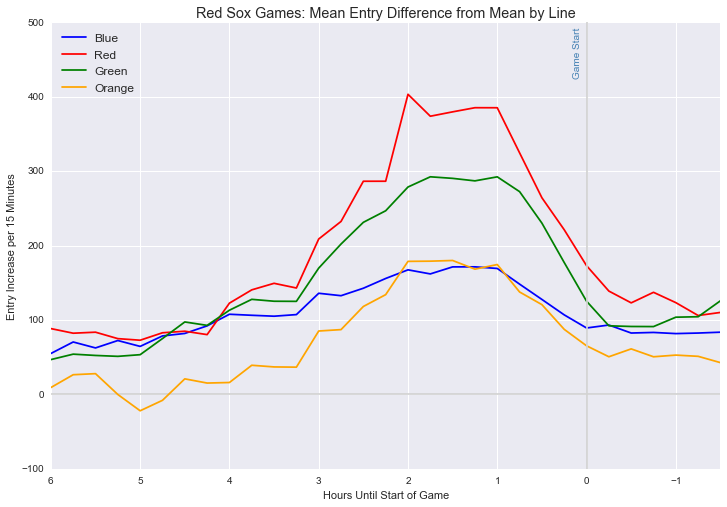

In [66]:
# Plot.

# Start plot.
plt.figure(figsize=default_figsize)
for line in line_entries.line.unique():
    if line != 'Silver':
        plt.plot(line_entries.ix[line_entries.line == line,'hours_until_game_start'], line_entries.ix[line_entries.line == line,'entries_vs_mean_per_line'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.0)
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean by Line', fontsize='x-large')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

In [57]:
# Add sum by line.
line_entries[(line_entries.hours_until_game_start > -.5) & (line_entries.line != 'Silver')].groupby('line').agg({'entries_vs_mean_per_line':np.sum}).sort('entries_vs_mean_per_line', ascending=False).head(n=10)

,entries_vs_mean_per_line
line,
Red,5269.707568
Green,4202.546729
Blue,2977.651295
Orange,1965.203061


Scatterplot by station:

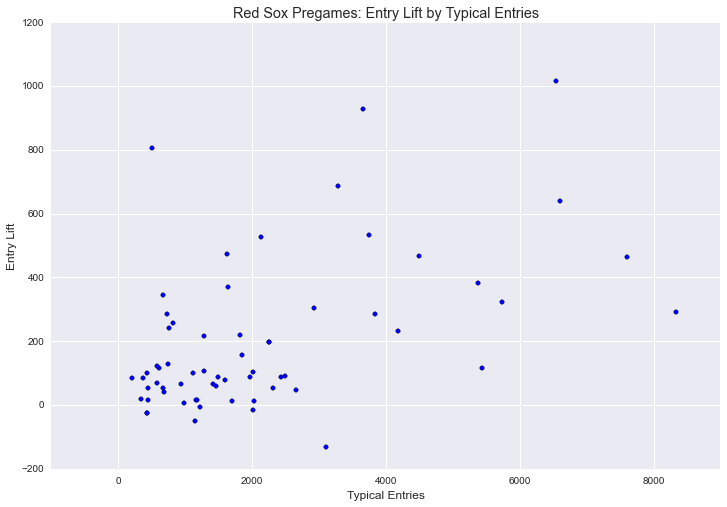

In [77]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.scatter(mean_entry_differences_dow_by_station.mean_entries, mean_entry_differences_dow_by_station.entries_vs_mean)
# Prettify.
plt.title('Red Sox Pregames: Entry Lift by Typical Entries', fontsize='x-large')
plt.xlabel('Typical Entries', fontsize='large')
plt.ylabel('Entry Lift', fontsize='large')
# Show.
plt.show()

### Farebox

Repeat the above for Farebox data.

In [22]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
gameless_entries_fb_dow = farebox_sox[farebox_sox.game_played == False]

# Aggregate.
gameless_entries_fb_dow = gameless_entries_fb_dow.groupby(['inbound','publicroute','day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_fb_dow.rename(columns={'entries':'mean_entries', 'entries_per_line': 'mean_entries_per_line_dir'}, inplace=True)

In [23]:
# Only consider entries before the game or slightly into it (to determine when entries dissipate.
gametime_condition = ((farebox_sox.time_until_game_start <= np.timedelta64(6,'h')) & (farebox_sox.time_until_game_start >= np.timedelta64(-90,'m')))
game_entries_fb_dow = farebox_sox[farebox_sox.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_fb_dow = game_entries_fb_dow.merge(gameless_entries_fb_dow, on=['inbound','publicroute','day_of_week','service_time'])[['inbound','publicroute','entries','time_until_game_start','mean_entries']]
entry_differences_fb_dow['entries_vs_mean'] = entry_differences_fb_dow.entries - entry_differences_fb_dow.mean_entries
entry_differences_fb_dow['entries_vs_mean_ratio'] = entry_differences_fb_dow.entries / entry_differences_fb_dow.mean_entries

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_fb_dow = entry_differences_fb_dow.groupby(['inbound','publicroute','time_until_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences_fb_dow.time_until_game_start = pd.to_timedelta(mean_entry_differences_fb_dow.time_until_game_start)
mean_entry_differences_fb_dow['hours_until_game_start'] = mean_entry_differences_fb_dow.time_until_game_start.astype(np.int) / timedelta_base

In [24]:
#### Extract useful information.
mean_entry_differences_fb_dow_truncated = mean_entry_differences_fb_dow[[0,1,7,3]].copy()
mean_entry_differences_fb_dow_truncated.columns = mean_entry_differences_fb_dow_truncated.columns.get_level_values(0)

In [ ]:
mean_entry_differences_fb_dow_truncated

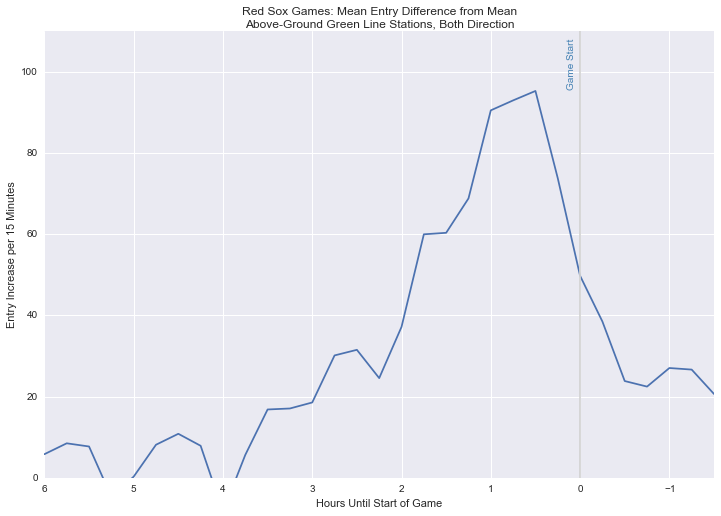

In [25]:
# Plot aggregate.

# Group by hours until start and aggregate.
mean_entry_differences_fb_dow_agg = mean_entry_differences_fb_dow_truncated.groupby('hours_until_game_start').agg(np.sum).reset_index()

# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(mean_entry_differences_fb_dow_agg.hours_until_game_start, mean_entry_differences_fb_dow_agg.entries_vs_mean)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean\nAbove-Ground Green Line Stations, Both Direction')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)

# Show.
plt.show()

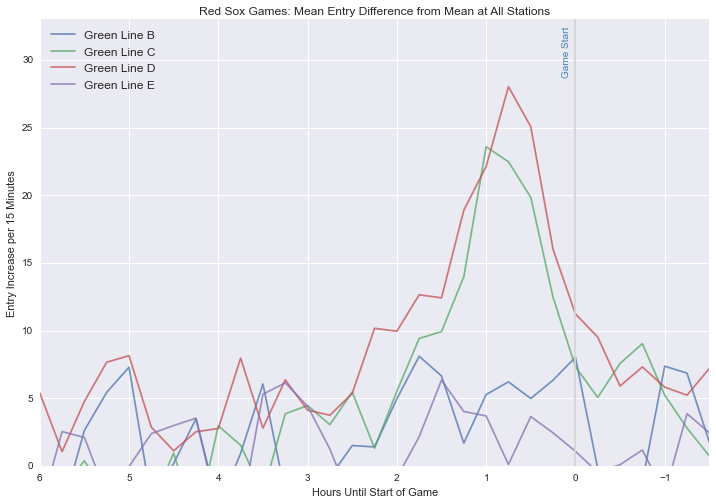

In [26]:
# Plot one line per inbound/outbound, public route.

# Get palette.
pal = sns.color_palette()

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for publicroute in mean_entry_differences_fb_dow.publicroute.unique():
    for inbound in [True]:
        # Get entries.
        route_entry_differences = mean_entry_differences_fb_dow[(mean_entry_differences_fb_dow.publicroute == publicroute) & (mean_entry_differences_fb_dow.inbound == inbound)]
        plt.plot(
            route_entry_differences.hours_until_game_start,
            route_entry_differences.entries_vs_mean['mean'],
            label=publicroute, #+' '+('Inbound' if inbound else 'Outbound'),
            # c=pal[1 if inbound else 2],
            alpha=0.75
        )

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at All Stations')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

In [27]:
# Aggregate across inbound/outbound.
publicroute_entries = mean_entry_differences_fb_dow_truncated.drop('inbound',axis=1).groupby(['publicroute','hours_until_game_start']).agg(np.sum).reset_index(drop=False)
# Add sum by line.
publicroute_entries[publicroute_entries.hours_until_game_start > -.5].groupby('publicroute').agg({'entries_vs_mean':np.sum}).sort('entries_vs_mean', ascending=False).head(n=10)

,entries_vs_mean
publicroute,
Green Line D,415.050642
Green Line C,289.452874
Green Line B,125.344228
Green Line E,18.081524


### Aggregate

Aggregate Gatecount and Farebox data; include Farebox data in Green Line.

In [46]:
# Reduce farebox entries to Green Line.
fb_entries_reduced = publicroute_entries.groupby('hours_until_game_start').agg({'entries_vs_mean': np.sum}).reset_index(drop=False)
fb_entries_reduced['line'] = 'Green'
fb_entries_reduced.rename(columns={'entries_vs_mean':'entries_vs_mean_per_line'}, inplace=True)
# Outer join to line entries for easy sum.
fb_gc_combined = line_entries.append(fb_entries_reduced)
fb_gc_agg = fb_gc_combined.groupby(['line','hours_until_game_start']).agg(np.sum).reset_index(drop=False)

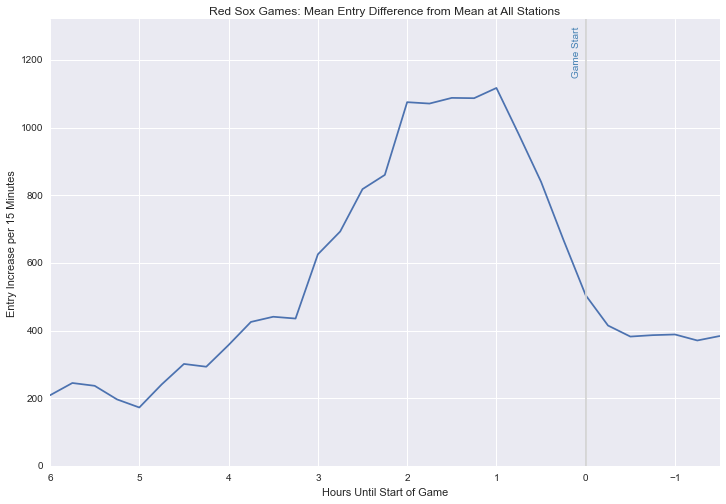

In [64]:
# Plot aggregate.

# Group by hours until start and aggregate.
fb_gcc_general = fb_gc_agg.groupby('hours_until_game_start').agg({'entries_vs_mean_per_line': np.sum}).reset_index(drop=False)

# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(fb_gcc_general.hours_until_game_start, fb_gcc_general.entries_vs_mean_per_line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at All Stations')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)

# Show.
plt.show()

Version for slides:

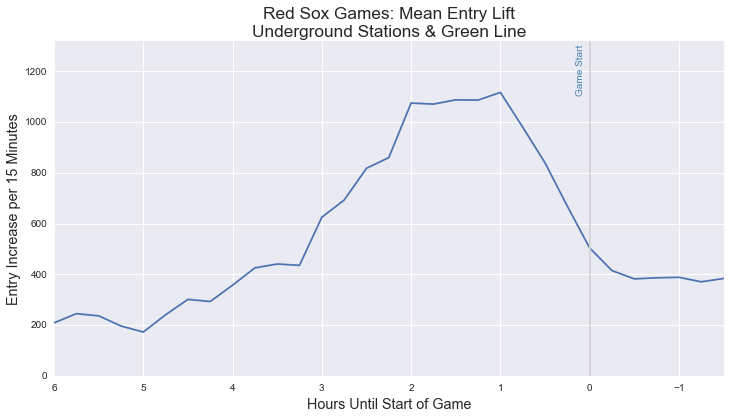

In [74]:
# Plot aggregate.

# Group by hours until start and aggregate.
fb_gcc_general = fb_gc_agg.groupby('hours_until_game_start').agg({'entries_vs_mean_per_line': np.sum}).reset_index(drop=False)

# Start plotting.
plt.figure(figsize=default_figsize_slides)
plt.plot(fb_gcc_general.hours_until_game_start, fb_gcc_general.entries_vs_mean_per_line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Lift\nUnderground Stations & Green Line', fontsize='xx-large')
plt.xlabel('Hours Until Start of Game', fontsize='x-large'); plt.ylabel('Entry Increase per 15 Minutes', fontsize='x-large')
plt.ylim(ylim)

# Show.
plt.show()

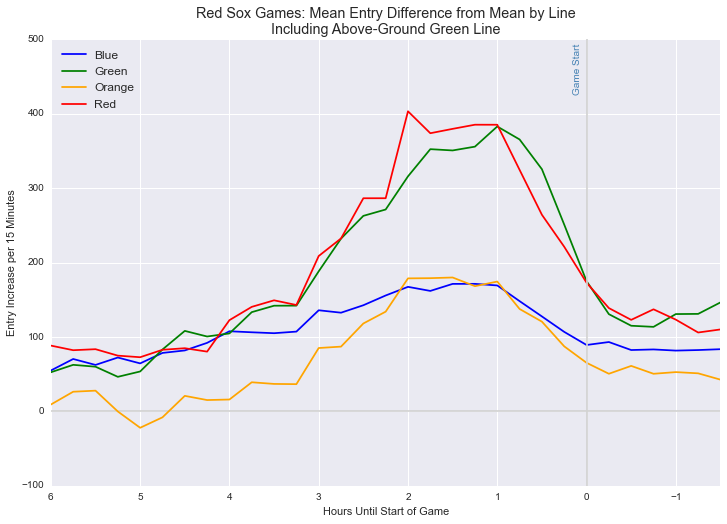

In [49]:
# Plot.

# Start plot.
plt.figure(figsize=default_figsize)
for line in fb_gc_agg.line.unique():
    if line != 'Silver':
        plt.plot(fb_gc_agg.ix[fb_gc_agg.line == line,'hours_until_game_start'], fb_gc_agg.ix[fb_gc_agg.line == line,'entries_vs_mean_per_line'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.0)
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean by Line\nIncluding Above-Ground Green Line', fontsize='x-large')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

Version for slides:

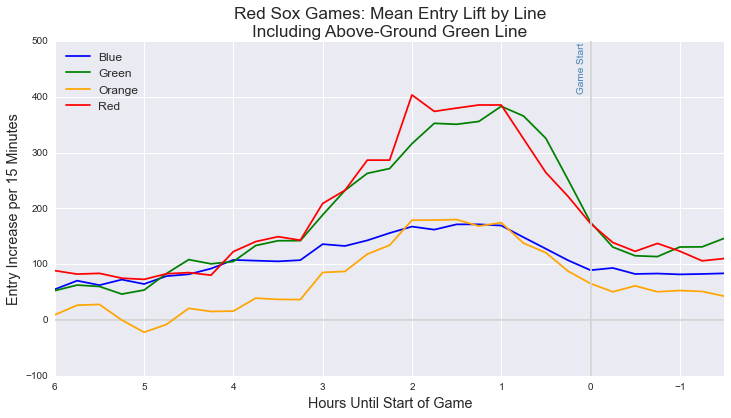

In [75]:
# Plot.

# Start plot.
plt.figure(figsize=default_figsize_slides)
for line in fb_gc_agg.line.unique():
    if line != 'Silver':
        plt.plot(fb_gc_agg.ix[fb_gc_agg.line == line,'hours_until_game_start'], fb_gc_agg.ix[fb_gc_agg.line == line,'entries_vs_mean_per_line'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.0)
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Lift by Line\nIncluding Above-Ground Green Line', fontsize='xx-large')
plt.xlabel('Hours Until Start of Game', fontsize='x-large'); plt.ylabel('Entry Increase per 15 Minutes', fontsize='x-large')
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()

In [67]:
# Add sum by line.
fb_gc_agg[(fb_gc_agg.hours_until_game_start > 0) & (fb_gc_agg.hours_until_game_start <= 4) & (fb_gc_agg.line != 'Silver')].groupby('line').agg({'entries_vs_mean_per_line':np.sum}).sort('entries_vs_mean_per_line', ascending=False).head(n=10)

,entries_vs_mean_per_line
line,
Red,4307.642118
Green,4177.254751
Blue,2217.703996
Orange,1779.668745


In [68]:
# General sum.
fb_gc_agg[(fb_gc_agg.hours_until_game_start > 0) & (fb_gc_agg.hours_until_game_start <= 4) & (fb_gc_agg.line != 'Silver')].sum()['entries_vs_mean_per_line']

12482.269609303628

In total, that's about **12,500** entries in the four hours preceding the game.